# Demo EfficientLoFTR on a single pair of images

This notebook shows how to use the eloftr matcher with different model type and numerical precision on the pretrained weights.

In [1]:
pwd

'/home/suren/Desktop/EfficientLoFTR_Modified/notebooks'

In [1]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

## Outdoor Example

We recommend using our pre-trained model for input in outdoor environments because our model has only been trained on MegaDepth, and there exists a domain gap between indoor and outdoor data.

In [2]:

from src.loftr import LoFTR, full_default_cfg, opt_default_cfg, reparameter

# You can choose model type in ['full', 'opt']
# model_type = 'full' # 'full' for best quality, 'opt' for best efficiency
model_type = 'full' # 'full' for best quality, 'opt' for best efficiency

# You can choose numerical precision in ['fp32', 'mp', 'fp16']. 'fp16' for best efficiency
# precision = 'fp32' # Enjoy near-lossless precision with Mixed Precision (MP) / FP16 computation if you have a modern GPU (recommended NVIDIA architecture >= SM_70).
precision = 'fp32' # Enjoy near-lossless precision with Mixed Precision (MP) / FP16 computation if you have a modern GPU (recommended NVIDIA architecture >= SM_70).

# You can also change the default values like thr. and npe (based on input image size)

if model_type == 'full':
    _default_cfg = deepcopy(full_default_cfg)
elif model_type == 'opt':
    _default_cfg = deepcopy(opt_default_cfg)
    
if precision == 'mp':
    _default_cfg['mp'] = True
elif precision == 'fp16':
    _default_cfg['half'] = True
    
print(_default_cfg)
matcher = LoFTR(config=_default_cfg)

# matcher.load_state_dict(torch.load("weights/eloftr_outdoor.ckpt")['state_dict'])
matcher.load_state_dict(torch.load("weights/eloftr_outdoor.ckpt", map_location=torch.device('cpu'))['state_dict'])
matcher = reparameter(matcher) # no reparameterization will lead to low performance

if precision == 'fp16':
    matcher = matcher.half()

# matcher = matcher.eval().cuda()
matcher = matcher.eval()

{'backbone_type': 'RepVGG', 'align_corner': False, 'resolution': (8, 1), 'fine_window_size': 8, 'mp': False, 'replace_nan': True, 'half': False, 'backbone': {'block_dims': [64, 128, 256]}, 'coarse': {'d_model': 256, 'd_ffn': 256, 'nhead': 8, 'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'agg_size0': 4, 'agg_size1': 4, 'no_flash': False, 'rope': True, 'npe': [832, 832, 832, 832]}, 'match_coarse': {'thr': 0.2, 'border_rm': 2, 'dsmax_temperature': 0.1, 'skip_softmax': False, 'fp16matmul': False, 'train_coarse_percent': 0.2, 'train_pad_num_gt_min': 200}, 'match_fine': {'local_regress_temperature': 10.0, 'local_regress_slicedim': 8}}


/tmp/ipykernel_10537/1057843242.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matcher.load_state_dict(torch.load("weights/eloftr_outdoor.ckpt", map_location=torch.dev

In [14]:
# Load example images
img0_pth = "dataset/images/pair_0001/image_1.png"
img1_pth = "dataset/images/pair_0001/image_2.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//32*32, img0_raw.shape[0]//32*32))  # input size shuold be divisible by 32
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//32*32, img1_raw.shape[0]//32*32))

if precision == 'fp16':
    img0 = torch.from_numpy(img0_raw)[None][None].half().cpu() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].half().cpu() / 255.
else:
    img0 = torch.from_numpy(img0_raw)[None][None].cpu() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cpu() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with EfficientLoFTR and get prediction
with torch.no_grad():
    if precision == 'mp':
        with torch.autocast(enabled=True, device_type='cpu'):
            matcher(batch)
    else:
        matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

/home/suren/miniconda3/envs/eloftr/lib/python3.8/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


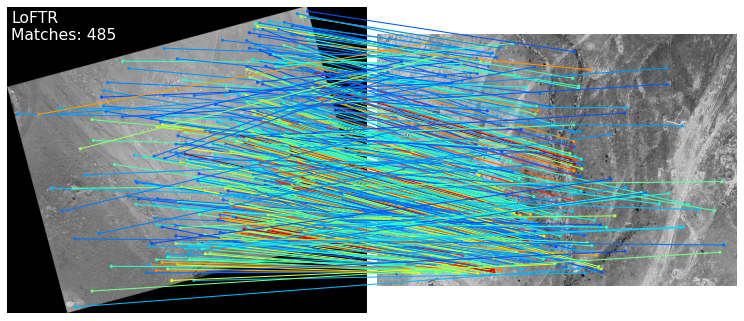

In [10]:
# Draw
if model_type == 'opt':
    print(mconf.max())
    mconf = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))

color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [7]:
matcher

LoFTR(
  (backbone): RepVGG_8_1_align(
    (layer0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_reparam): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (layer1): ModuleList(
      (0-1): 2 x RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (layer2): ModuleList(
      (0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1-3): 3 x RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (layer3): ModuleList(
      (0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2),